In [19]:
# import packages
import pandas as pd
import numpy as np
import datetime
import math
import jpholiday
from scipy.optimize import minimize, BFGS, LinearConstraint
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt

from SEIRWWfiles_R2S.SEIRWWcalibrate import SEIRWWcalibrate
from SEIRWWfiles_R2S.SEIRWWinit import SEIRWWinit


from SEIRWWfiles_R2S.DataBase import get_dataframe

In [20]:
import scipy as sp
print(pd.__version__)
print(np.__version__)
print(sp.__version__)
import platform
print(platform.system())
print(platform.release())

1.3.5
1.21.6
1.7.3
Linux
4.19.0-25-cloud-amd64


In [21]:
# Run control
run_config = pd.read_csv('run_config.txt', sep=":")
run_config = run_config.transpose()

# Drop data by date
f_date = str(run_config.date_cut_from.iloc[0].strip())
l_date = str(run_config.date_cut_learn.iloc[0].strip())
t_date = str(run_config.date_cut_to.iloc[0].strip())

# Set global variables
geom_id = int(run_config.geom_id.iloc[0])
geom_id_idx = run_config.geom_id_idx.iloc[0].strip()

ww_idx = run_config.ww_idx.iloc[0].strip()
assay_method = run_config.assay_method.iloc[0].strip()
regionName = run_config.region_name.iloc[0].strip()
setting_path = run_config.setting_path.iloc[0].strip()
spe_day_flg = bool(run_config.spe_day_flg.iloc[0].strip())
N_days_pred = int(run_config.N_days_pred.iloc[0])
aggregation = run_config.aggregation[0].strip()
# vaccine setting
vaccine_efficacy_rate = float(run_config.vaccine_efficacy_rate.iloc[0])
acutial_vaccination_rate = float(run_config.acutial_vaccination_rate.iloc[0])
# contact reduce rate setting
contact_reduce_rate = float(run_config.contact_reduce_rate.iloc[0])
# s_init setting
s_init = float(run_config.s_init.iloc[0])
run_config

,date_cut_from,date_cut_learn,date_cut_to,auto_date_cut,region_name,debug,geom_id_idx,geom_id,aggregation,assay_method,ww_idx,setting_path,spe_day_flg,N_days_pred,vaccine_efficacy_rate,acutial_vaccination_rate,contact_reduce_rate,s_init
key value,2022-07-08,2022-12-27,2022-12-27,True,Kanagawa,True,geom_id_1,6,gmean,CM,covn_1_to_pmmov_user01,./settings/settings.xlsx,True,120,0.6,0.7,0.10,0.8906546


In [22]:
#figure_title="Kyoto (COPMAN)"
#figure_title="City A (EPISENS-S)" #figure_title="city-a (EPISENS-S)"
#figure_title="Kanagawa (EPISENS-S)"
figure_title="Kanagawa (COPMAN)"

# Get data
if figure_title=="Kyoto (COPMAN)":
    df_tmp0 = pd.read_excel("./data-ww-case/Kyoto-CM.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/Kyoto-cases.xlsx")
elif figure_title=="Kanagawa (EPISENS-S)":
    df_tmp0 = pd.read_excel("./data-ww-case/Kanagawa-HS.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/Kanagawa-cases.xlsx")
elif figure_title=="Kanagawa (COPMAN)":
    df_tmp0 = pd.read_excel("./data-ww-case/Kanagawa-CM.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/Kanagawa-cases.xlsx")
elif figure_title=="City A (EPISENS-S)":
    df_tmp0 = pd.read_excel("./data-ww-case/city-a-HS.xlsx")
    df_tmp1 = pd.read_excel("./data-ww-case/city-a-cases.xlsx")

df_tmp = pd.merge(df_tmp1, df_tmp0, how="outer", on="date")
#df_merged = df_tmp[["date","ww","cases"]]
df_merged = df_tmp[["date","ww-pmmov","cases","rmk"]]
df_merged = df_merged.rename(columns={"ww-pmmov":"ww"})
df_merged = df_merged.sort_values("date")
if figure_title=="Kyoto (COPMAN)":
    df_merged["cases"] = df_merged["cases"]*778000/1448964 #Kyoto calibration

# Only if the rmk is ND, else set rmk as nan
df_merged.rmk = np.where(df_merged.rmk=="ND",df_merged.rmk, np.nan)
df_merged.head(10)

,date,ww,cases,rmk
0,2021-11-01,NaN,1.007429,NaN
1,2021-11-02,NaN,1.439714,NaN
2,2021-11-03,NaN,1.293143,NaN
3,2021-11-04,NaN,1.011143,NaN
4,2021-11-05,NaN,0.868286,NaN
5,2021-11-06,NaN,0.872000,NaN
6,2021-11-07,NaN,0.729143,NaN
7,2021-11-08,NaN,0.729143,NaN
8,2021-11-09,NaN,0.304286,NaN
9,2021-11-10,NaN,0.732857,NaN


In [23]:
try:
    df_train = df_merged[df_merged.date>=datetime.datetime(int(f_date.split("-")[0]),
                                                           int(f_date.split("-")[1]),
                                                           int(f_date.split("-")[2]))]
except:
    print("Warning: Cannot do from date cut", f_date)
try:
    df_train = df_train[df_train.date<=datetime.datetime(int(l_date.split("-")[0]),
                                                         int(l_date.split("-")[1]),
                                                         int(l_date.split("-")[2]))]
except:
    print("Warning: Cannot do to date cut",l_date)
# Get valiration data
try:
    df_valid = df_merged[df_merged.date>=datetime.datetime(int(f_date.split("-")[0]),
                                                           int(f_date.split("-")[1]),
                                                           int(f_date.split("-")[2]))]
except:
    print("Warning: Cannot get validation data",f_date)

try:
    df_valid = df_valid[df_valid.date<=datetime.datetime(int(t_date.split("-")[0]),
                                                       int(t_date.split("-")[1]),
                                                       int(t_date.split("-")[2]))]
except:
    print("Warning: Cannot do to date cut",t_date)    

# Create a date index dictionary    
dict_date_idx = {}
for i, val in enumerate(df_valid.date):
    if val in dict_date_idx.keys():
        print("Repeated dateTime, please check", i, val)
    else:
        dict_date_idx[val] = i
        
# Reset index
df_train = df_train.reset_index()
df_valid = df_valid.reset_index()
print(len(df_train))
df_train[["date","ww","cases"]][df_train["ww"]>0].head(10)
#df_train["cases"] = np.where(df_train["cases"]==0, 1,df_train["cases"])
df_train[["date","ww","cases"]]

173


,date,ww,cases
0,2022-07-08,0.000149,449.122000
1,2022-07-09,NaN,505.257143
2,2022-07-10,NaN,571.132000
3,2022-07-11,NaN,645.108857
4,2022-07-12,0.000480,692.503429
...,...,...,...
168,2022-12-23,0.000498,2357.016000
169,2022-12-24,NaN,2557.696000
170,2022-12-25,NaN,2234.194000
171,2022-12-26,NaN,1233.638000


# Get Japanese Holidays

In [24]:
start_year = 2021
end_year   = 2023
holiday  = jpholiday.between(datetime.datetime(start_year, 1, 1), datetime.datetime(end_year, 12, 31))
df_holiday = pd.to_datetime([x[0] for x in holiday], format="%Y/%m/%d")

In [25]:
# Set initial parameters
settings = pd.read_excel("./settings/settings.xlsx")
settings_target = settings[settings['region'] == regionName].reset_index()
params = {}
params['region'] = regionName
params['N'] = settings_target['N'][0]

# Check length of reporting rate
cnt_rrate_val = len(str(settings_target['reporting rate (value)'][0]).split(","))
cnt_rrate_idx = len(str(settings_target['reporting rate (start index)'][0]).split(","))
if cnt_rrate_val !=cnt_rrate_idx:
    raise Exception("Error invalid reporting rate values")

# Fill params reporting rate
dlist = np.empty((0,2))
for i in range(cnt_rrate_val):
    s_date_time = str(settings_target['reporting rate (start index)'][0]).split(',')[i]
    
    # If the first setting is zero, filling everything with constant from the beginning of the data
    if s_date_time!="0":
        date_time = pd.Timestamp(s_date_time)
    else:
        date_time = pd.Timestamp(df_train.date.iloc[0])
    _dlist = [str(settings_target['reporting rate (value)'][0]).split(',')[i], dict_date_idx[date_time]]
    _dlist = [float(s) for s in _dlist]
    dlist = np.vstack([dlist, _dlist])
params['reporting rate'] = dlist

specialHolidays = []
if spe_day_flg == True:
    # Fill params Special holiday
    if (len(settings_target['specialHolidays'])==0):
        specialHolidays = []
    else:
        d_specialHolidays = str(settings_target['specialHolidays'][0]).split(',')
        for i in d_specialHolidays:
            try:
                idx = dict_date_idx[pd.Timestamp(i)]
                specialHolidays.append(int(idx))
            except:
                print("Cannot find special holiday:",i)
                
# Path of the data file
datafile = './data/' + params['region'] + '.xlsx'

#TT = pd.read_excel(datafile)
TT = df_train[["date","cases","ww"]]
TT = TT.reset_index()
YC = TT['cases']
YW = TT['ww']
TT_valid = df_valid[["date","cases","ww"]]
YC_valid = TT_valid['cases']
YW_valid = TT_valid['ww']

Cannot find special holiday: 2021/1/1
Cannot find special holiday: 2021/1/11
Cannot find special holiday: 2021/2/11
Cannot find special holiday: 2021/2/23
Cannot find special holiday: 2021/3/20
Cannot find special holiday: 2021/4/29
Cannot find special holiday: 2021/5/3
Cannot find special holiday: 2021/5/4
Cannot find special holiday: 2021/5/5
Cannot find special holiday: 2021/7/20
Cannot find special holiday: 2021/8/8
Cannot find special holiday: 2021/8/9
Cannot find special holiday: 2021/9/20
Cannot find special holiday: 2021/9/23
Cannot find special holiday: 2021/11/3
Cannot find special holiday: 2021/11/23
Cannot find special holiday: 2022/1/10
Cannot find special holiday: 2022/2/11
Cannot find special holiday: 2022/2/23
Cannot find special holiday: 2022/3/21
Cannot find special holiday: 2022/4/29
Cannot find special holiday: 2022/5/3
Cannot find special holiday: 2022/5/4
Cannot find special holiday: 2022/5/5


In [26]:
# Determine c_t
C = SEIRWWinit(YC,specialHolidays, params['reporting rate'])

# Calibrate the model and save parameters
print(params)
params = SEIRWWcalibrate(YC,YW,C,params,s_init)
params['specialHolidays'] = specialHolidays
params["s_init"] = s_init
np.save('./parameters/params_' + params['region'] + '_R2S.npy',params)
if run_config.debug.iloc[0]:
    print(params)

{'region': 'Kanagawa', 'N': 1241200, 'reporting rate': array([[1.8, 0. ]])}


KeyError: 'darkNumber'

In [8]:
# Write a copy of params to result
params

{'region': 'Kanagawa',
 'N': 1241200,
 'darkNumber': array([[1.8, 0. ]]),
 'alpha': 0.6666666666666666,
 'beta': 0.44,
 'tau': 0.5,
 'omega': 0.005555555555555556,
 'modelErrorC': 16,
 'S_beta': 0.0225,
 'Q_beta0': 0.0025000000000000005,
 'Q_beta1': 2.5e-05,
 'E_init': 1548.7866514440002,
 'I_init': 2065.048868592,
 'varE_init': 599685.0229227798,
 'varI_init': 1066106.7074182748,
 'gamma': 1.744768896534756,
 'WWexp': 0.7425385172442044,
 'RW0': 1.0103560305646817e-17,
 'RW': 1.0103560305646817e-18,
 'nu': 1.6862709558615567e-11,
 'sigma': 1,
 'specialHolidays': [10, 34, 73, 77, 94, 118, 138],
 's_init': 0.8906546}

In [9]:
# import packages
import os
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#from datetime import datetime, timedelta
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages

from SEIRWWfiles_R2S.SEIR_WW import SEIR_WW
from SEIRWWfiles_R2S.SEIRWWinit import SEIRWWinit
from SEIRWWfiles_R2S.WWinterpol import WWinterpol
from SEIRWWfiles_R2S.SEIR_WW_FWD import SEIR_WW_FWD
from SEIRWWfiles_R2S.prediction import prediction

# Path of thr output file
outputfile = './results/' + regionName
pdf = PdfPages(outputfile + '/Summary_' + regionName + '_R2S_Vaccine.pdf')

# Convert the dictionary to a dataframe
df_par = pd.DataFrame.from_dict(params,orient="index")

# Save the data as a CSV file
df_par.to_csv(outputfile+'/params.csv')

In [10]:
# Save run config to data as meta data
run_config.to_csv(outputfile+'/run_config.csv')

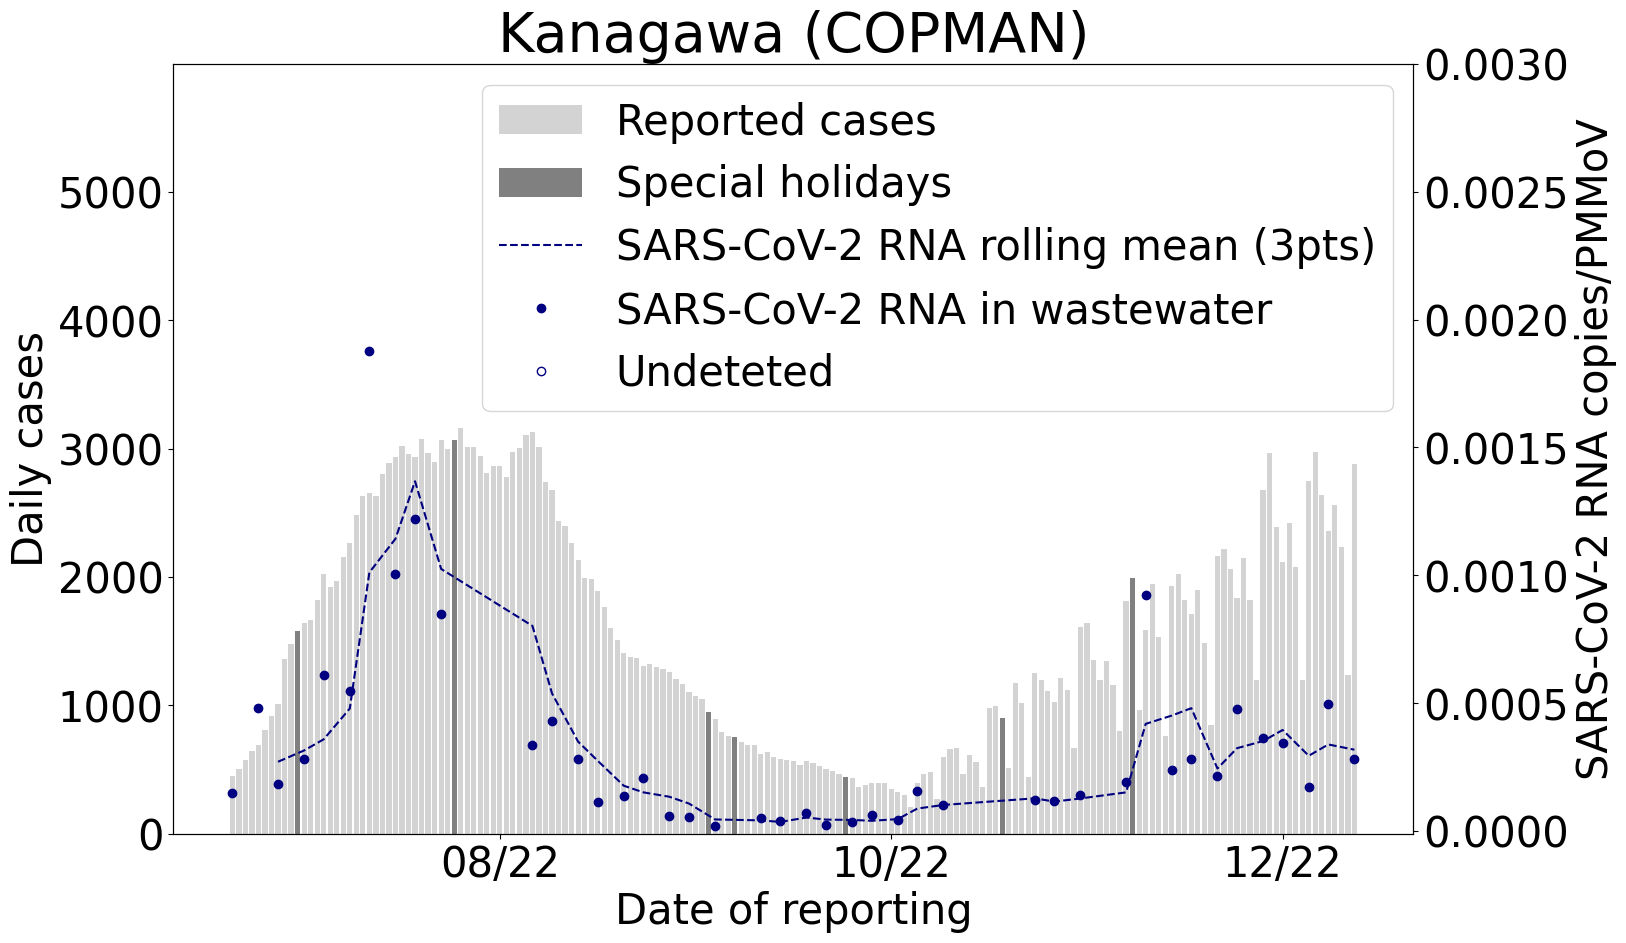

In [11]:
# Plot input data
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
ax1.set_title(figure_title, fontsize=40)
ax1.set_xlabel('Date of reporting',fontsize=30)
ax1.set_ylabel('Daily cases',fontsize=30)
ax1.tick_params(axis="both", labelsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
ax1.xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
# Draw validation data
ax1.bar(df_valid["date"],df_valid["cases"],color="lightgrey",label="Reported cases")
#ax1.set_ylim([0,df_valid["cases"].max()*1.5])

if figure_title=="City A (EPISENS-S)":
    ax1_set = [0,400,100] # city-a
elif figure_title=="Kyoto (COPMAN)":
    ax1_set = [0,5000,1000] # Kyoto
elif figure_title=="Kanagawa (COPMAN)":
    ax1_set = [0,6000,1000] # Kanagawa EPIS
elif figure_title=="Kanagawa (EPISENS-S)":
    ax1_set = [0,6000,1000] # Kanagawa EPIS

ax1.set_ylim(ax1_set[0:2])
ax1.set_yticks(range(ax1_set[0],ax1_set[1],ax1_set[2]))
ax2 = ax1.twinx()
ax2.set_ylabel('SARS-CoV-2 RNA copies/PMMoV',fontsize=30)

if figure_title=="City A (EPISENS-S)":
    ax2_set = [-0.001,0.03,0.005] # city-a
elif figure_title=="Kyoto (COPMAN)":
    ax2_set = [-1e-5,6e-4,1e-4] # Kyoto COPMAN
elif figure_title=="Kanagawa (COPMAN)":    
    ax2_set = [-0.00001,0.003,0.0005] # Kanagawa COPMAN
elif figure_title=="Kanagawa (EPISENS-S)":
    ax2_set = [-0.001,0.02,0.005] #Kanagawa episens-s
    
ax2.set_ylim(ax2_set[0:2])
#ax2.set_yticks(range(ax2_set[0],ax2_set[1],ax2_set[2]))
ax2.tick_params(axis="y", labelsize=30)
# Set tick frequency
tick_frequency = 0.5
ax2.yaxis.set_major_locator(ticker.MultipleLocator(ax2_set[2]))


df_tmp=df_valid[["date","ww"]].copy()
df_tmp["ww"]=np.where(df_tmp["ww"]<0,np.nan,df_tmp["ww"])
df_tmp=df_tmp.dropna()
#ax2.plot(df_tmp["date"],df_tmp["ww"],linestyle="", marker="o",markeredgecolor="blue",color="None", label="SARS-CoV-2 RNA in wastewater(testing set)")
#ax2.plot(df_tmp["date"],df_tmp["ww"].rolling(3).mean(),linestyle="--", marker="",color="blue",label="SARS-CoV-2 RNA rolling mean(testing set)")


# Speical holiday_plots
if spe_day_flg == True:
    list_spc_days = [ pd.Timestamp(i) for i in str(settings_target['specialHolidays'][0]).split(',')]
    df_sp_dt = pd.DataFrame(list_spc_days, columns = ['date'])
    df_sp_dt_m = pd.merge(df_sp_dt, df_valid[["date","cases"]],on="date", how="left")
    df_sp_dt_m = df_sp_dt_m.dropna()
    ax1.bar(df_sp_dt_m["date"],df_sp_dt_m["cases"],color="grey",label="Special holidays")


# Overlay training data
df_tmp=df_train[["date","ww"]].copy()
df_tmp=df_tmp.dropna()
ax2.plot(df_tmp["date"],df_tmp["ww"].rolling(3).mean(),linestyle="--", marker="",color="navy",label="SARS-CoV-2 RNA rolling mean (3pts)")
ax2.plot(df_tmp["date"],df_tmp["ww"],linestyle="", marker="o",color="navy", label="SARS-CoV-2 RNA in wastewater")
# Draw BLQ
# Draw ND
df_tmp=df_train[["date","ww","rmk"]].copy()
df_tmp=df_tmp.dropna()
ax2.plot(df_tmp["date"],df_tmp["ww"],linestyle="", marker="o",color="navy",markerfacecolor= 'white', label="Undeteted")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
#ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=30, ncol=1)
ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize=30, ncol=1)

fig.savefig(outputfile + '/Plot_the_case_number_and_wastewater_data_' + regionName + '.png',bbox_inches="tight") 
pdf.savefig(fig, bbox_inches="tight")

In [12]:
# Read saved parameters
params = np.load('./parameters/params_' + regionName + '_R2S.npy', allow_pickle=True)
params = params.item()

C = SEIRWWinit(YC, params['specialHolidays'], params['reporting rate'])

# Esimate the case numbers using only the wastewater data
params['RW'] = params['RW0']/10
result = SEIR_WW(params,YC,YW,C,[False,True],1000, s_init)
Yest = result[0][0]
Ysd = result[5][0] ** 0.5
YTest = result[6][0]
Xend = result[1][0]

Yest_movmean = pd.Series(Yest).rolling(window=7, min_periods=1).mean()
YTest_movmean = pd.Series(YTest).rolling(window=7, min_periods=1).mean()
YC_movmean = YC.rolling(window=7, min_periods=1).mean()
Ysd_movmean = pd.Series(Ysd).rolling(window=7, min_periods=1).mean()
maxsd = Yest_movmean + 2 * Ysd_movmean
minsd = Yest_movmean - 2 * Ysd_movmean
#maxsd = Yest_movmean + np.abs(YC_movmean-Yest_movmean)*2
#minsd = Yest_movmean - np.abs(YC_movmean-Yest_movmean)*2
minsd[minsd < 0] = 0

mae = round(mean_absolute_error(YC, Yest),3)
rmse = round(np.sqrt(mean_squared_error(YC, Yest)),3)

In [13]:
print(params["N"],Xend,Xend/params["N"])

1241200 [932801.34110095] [0.75153186]


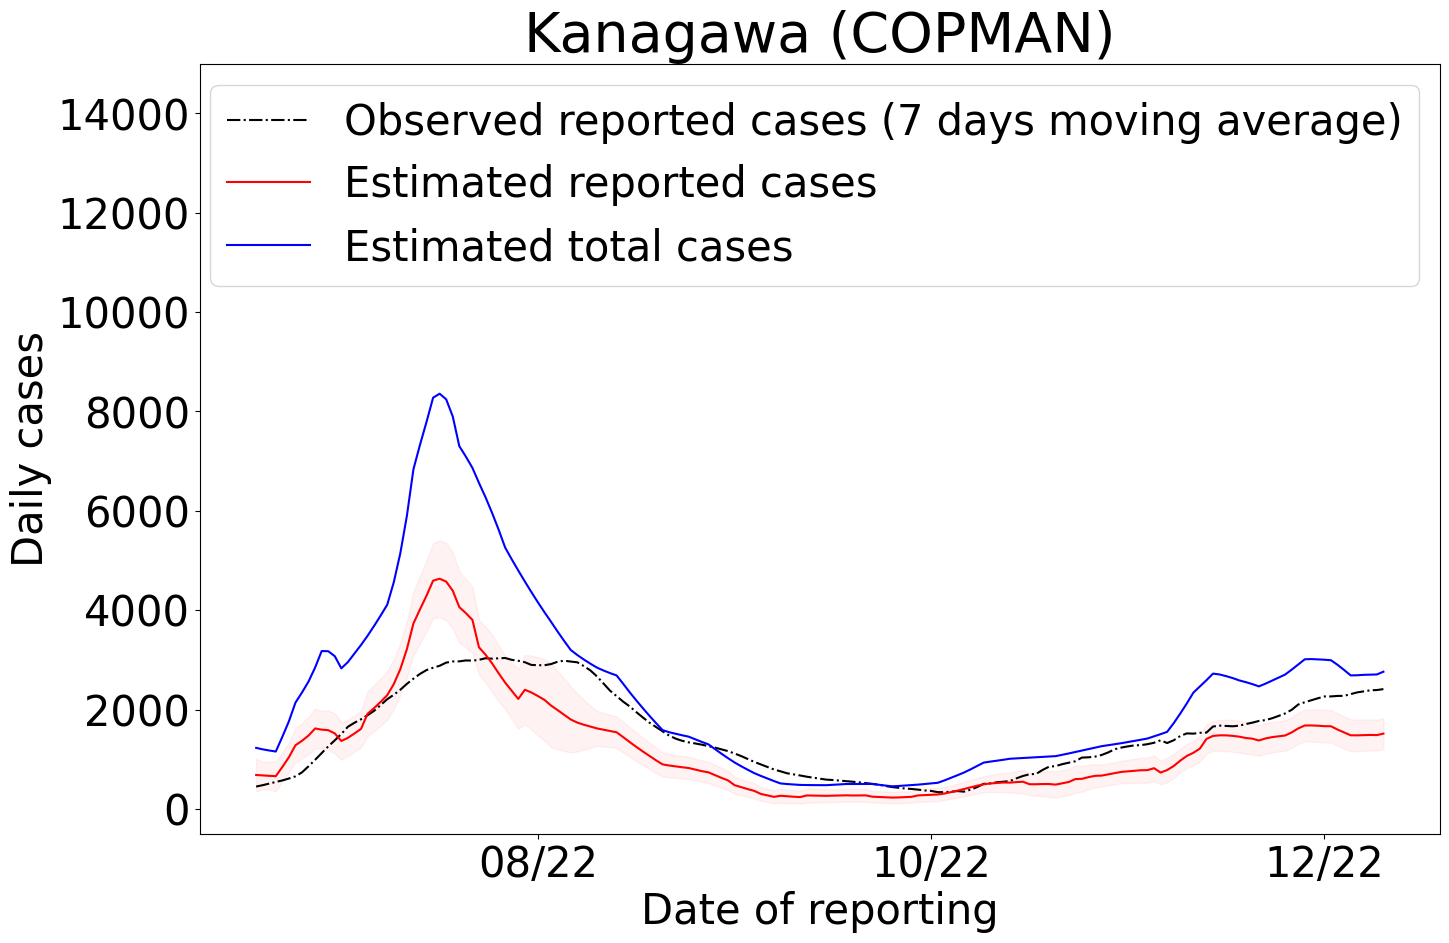

In [14]:
fig = plt.figure(figsize=(16,10))

plt.plot(TT['date'], YC_movmean, ls='-.' , label='Observed reported cases (7 days moving average)', color='k')
plt.plot(TT['date'], Yest_movmean, label='Estimated reported cases', color="r")
#plt.fill_between(TT['date'], maxsd, minsd, color='b', alpha=0.2, label='Estimated cases 95% C.L.)
plt.fill_between(TT['date'], maxsd, minsd, color='r', alpha=0.05)
plt.plot(TT['date'], YTest_movmean, label='Estimated total cases', color='b')

plt.title(figure_title,fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Daily cases',fontsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

if figure_title=="City A (EPISENS-S)":
    plt.ylim([-50,500]) # city-a
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-5000/100,5000]) # Kyoto
elif figure_title=="Kanagawa (COPMAN)":    
    plt.ylim([-500,15000]) #Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-500,15000]) #Kanagawa
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
#plt.grid()

plt.savefig(outputfile + '/Esimate_the_case_numbers_using_only_the_wastewater_data_' + regionName + '.png',bbox_inches="tight") 
pdf.savefig(fig,bbox_inches="tight")

In [15]:
# R_eff estimates from case data and WW data
result = SEIR_WW(params,YC,YW,C,[True,False],1000,s_init)
ReffCase = result[3]
ReffCaseSD = result[4][0]
result = SEIR_WW(params,YC,YW,C,[False,True],1000,s_init)
ReffWW = result[3]
ReffWWSD = result[4][0]

# Get R_eff calculated by R package epiestim
if figure_title=="City A (EPISENS-S)":
    df_reff_rcal = pd.read_excel("./r_eff/reproduction_number_city-a.xlsx")
elif figure_title=="Kyoto (COPMAN)":
    df_reff_rcal = pd.read_excel("./r_eff/reproduction_number_kyoto.xlsx")
elif figure_title=="Kanagawa (COPMAN)":
    df_reff_rcal = pd.read_excel("./r_eff/reproduction_number_kanagawa_cop.xlsx")
elif figure_title=="Kanagawa (EPISENS-S)":
    df_reff_rcal = pd.read_excel("./r_eff/reproduction_number_kanagawa.xlsx")
df_reff = df_reff_rcal[["dates","Mean(R)","Std(R)"]]
df_reff['dates'] = pd.to_datetime(df_reff['dates'])

try:
    df_reff = df_reff[df_reff.dates>=datetime.datetime(int(f_date.split("-")[0]),
                                                           int(f_date.split("-")[1]),
                                                           int(f_date.split("-")[2]))]
except:
    print("Warning: Cannot do from date cut", f_date)
try:
    df_reff = df_reff[df_reff.dates<=datetime.datetime(int(t_date.split("-")[0]),
                                                       int(t_date.split("-")[1]),
                                                       int(t_date.split("-")[2]))]
except:
    print("Warning: Cannot do to date cut",t_date)    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
df_reff_rcal

,dates,I,t_start,t_end,Mean(R),Std(R),Quantile.0.025(R),Quantile.0.05(R),Quantile.0.25(R),Median(R),Quantile.0.75(R),Quantile.0.95(R),Quantile.0.975(R)
0,2022-07-15,1010.339143,2,8,1.864253,0.025977,1.813683,1.821732,1.846667,1.864132,1.881707,1.907185,1.915508
1,2022-07-16,1361.660285,3,9,1.734936,0.022385,1.691336,1.698280,1.719785,1.734839,1.749981,1.771919,1.779083
2,2022-07-17,1482.009428,4,10,1.660280,0.019962,1.621384,1.627583,1.646773,1.660200,1.673700,1.693250,1.699631
3,2022-07-18,1580.146857,5,11,1.593182,0.017978,1.558137,1.563726,1.581019,1.593114,1.605271,1.622869,1.628611
4,2022-07-19,1641.530286,6,12,1.532156,0.016331,1.500313,1.505393,1.521109,1.532098,1.543139,1.559117,1.564329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2023-01-29,560.222000,200,206,0.852578,0.011135,0.830891,0.834345,0.845041,0.852529,0.860062,0.870976,0.874540
199,2023-01-30,346.658000,201,207,0.868752,0.011504,0.846349,0.849917,0.860965,0.868701,0.876484,0.887761,0.891444
200,2023-01-31,809.060000,202,208,0.842699,0.011565,0.820183,0.823767,0.834870,0.842646,0.850470,0.861811,0.865515
201,2023-02-01,791.638000,203,209,0.811818,0.011598,0.789243,0.792835,0.803965,0.811763,0.819611,0.830989,0.834707


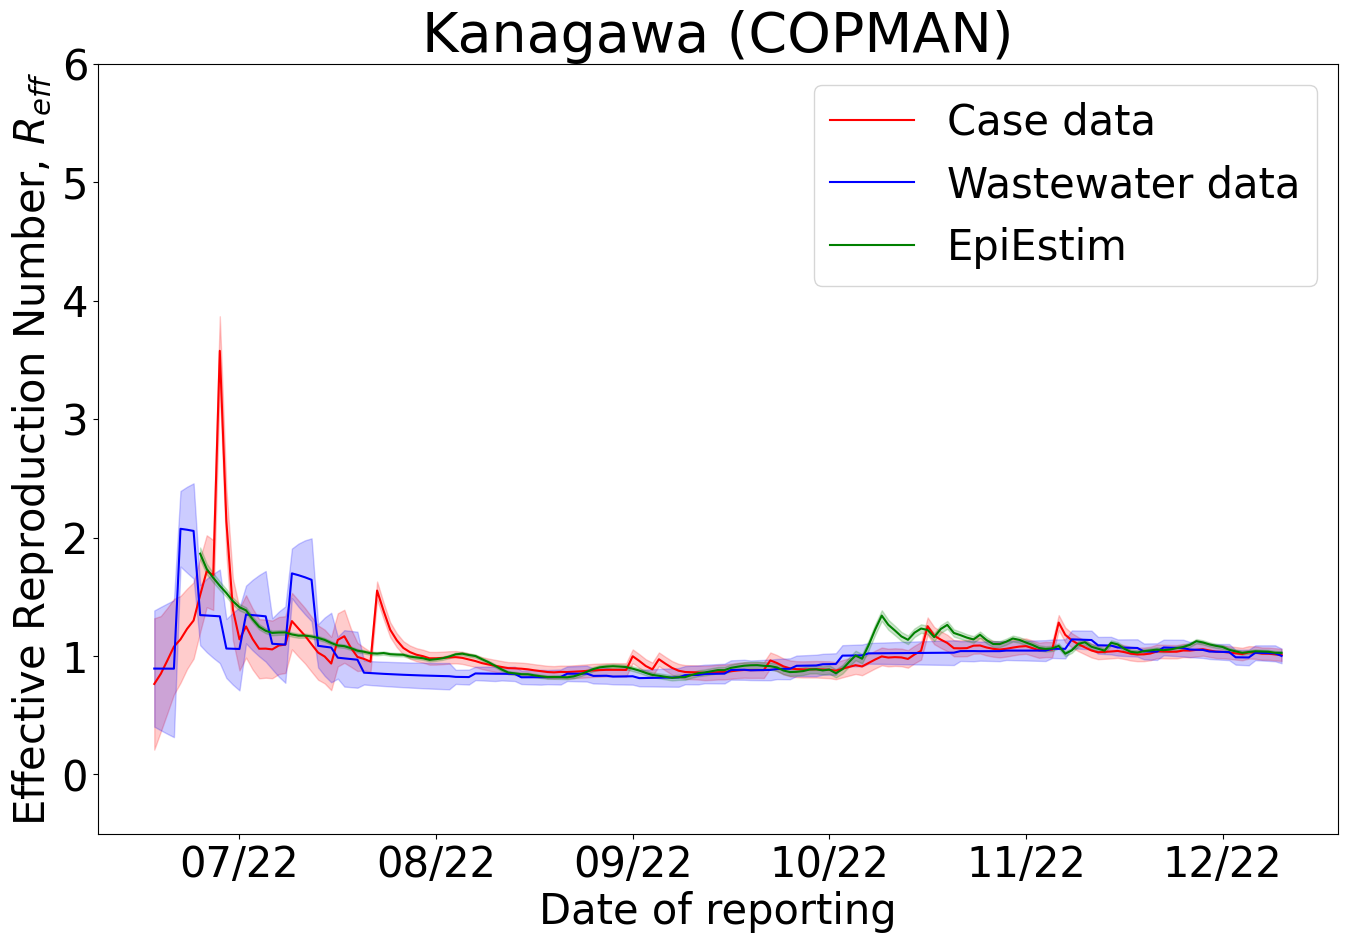

In [17]:
fig = plt.figure(figsize=(16,10))

plt.plot(TT['date'], ReffCase, label='Case data', color='r')
y1 = ReffCase + 2 * ReffCaseSD
y2 = ReffCase - 2 * ReffCaseSD
y2 = np.where(y2<0, 0, y2)
plt.fill_between(TT['date'], y1, y2 , where=y2 >= 0, color='r', alpha=0.2)
plt.plot(TT['date'], ReffWW, label='Wastewater data', color='b')
y1 = ReffWW + 2 * ReffWWSD
y2 = ReffWW - 2 * ReffWWSD
y2 = np.where(y2<0, 0, y2)
plt.fill_between(TT['date'],y1,y2,color='b', alpha=0.2)

plt.plot(df_reff['dates'], df_reff["Mean(R)"], label='EpiEstim', color='g')
y1 = df_reff["Mean(R)"] + 2 * df_reff["Std(R)"]
y2 = df_reff["Mean(R)"] - 2 * df_reff["Std(R)"]
y2 = np.where(y2<0, 0, y2)
plt.fill_between(df_reff['dates'],y1,y2,color='g', alpha=0.2)

plt.title(figure_title,fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Effective Reproduction Number, $R_{eff}$',fontsize=30)
plt.ylim([-0.5,6.0])
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
#plt.grid()

plt.savefig(outputfile + '/R_eff_estimates_from_case_data_and_WW_data_' + regionName + '.png',bbox_inches="tight")
pdf.savefig(fig,bbox_inches="tight")

In [18]:
# Long estimate the case numbers (vaccination scenario) 
# At what date is the forward prediction done
predDay = len(YC)
# Use case/WW data or both
dataToUse = [True, True]

params['RW'] = params['RW0']/10
result = SEIR_WW(params,YC,YW,C,dataToUse,predDay,s_init)
XendC = result[1].T[0]
PC = result[2]

Y0, err = SEIR_WW_FWD(XendC,C,PC,predDay,params,N_days_pred)
Xaux = np.copy(XendC)
Xaux[6] = XendC[6] * (1 -  vaccine_efficacy_rate * 0.8) / (1 - vaccine_efficacy_rate * acutial_vaccination_rate)
Y0_80, err_80 = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Xaux[6] = XendC[6] * (1 -  vaccine_efficacy_rate * 0.9) / (1 - vaccine_efficacy_rate * acutial_vaccination_rate)
Y0_90, err_90 = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Yc0 = np.cumsum(np.hstack([YC[0:predDay],Y0[0,:]]))
Yc0_80 = np.cumsum(np.hstack([YC[0:predDay],Y0_80[0,:]]))
Yc0_90 = np.cumsum(np.hstack([YC[0:predDay],Y0_90[0,:]]))

# actual vacctination rate
Xaux[6] = XendC[6] + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Y2 = result[0]
Yc2 = np.cumsum(np.hstack([YC[0:predDay],Y2[0,:]]))

Xaux[6] = XendC[6] - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Ym2 = result[0]
Ycm2 = np.cumsum(np.hstack([YC[0:predDay],Ym2[0,:]]))

# 80 percent vacctination rate
Xaux[6] = XendC[6] * (1 -  vaccine_efficacy_rate * 0.8) / (1 - vaccine_efficacy_rate * acutial_vaccination_rate) + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Y2_80 = result[0]
Yc2_80 = np.cumsum(np.hstack([YC[0:predDay],Y2_80[0,:]]))

Xaux[6] = XendC[6] * (1 -  vaccine_efficacy_rate * 0.8) / (1 - vaccine_efficacy_rate * acutial_vaccination_rate) - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Ym2_80 = result[0]
Ycm2_80 = np.cumsum(np.hstack([YC[0:predDay],Ym2_80[0,:]]))

# 90 percent vacctination rate
Xaux[6] = XendC[6] * (1 -  vaccine_efficacy_rate * 0.9) / (1 - vaccine_efficacy_rate * acutial_vaccination_rate) + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Y2_90 = result[0]
Yc2_90 = np.cumsum(np.hstack([YC[0:predDay],Y2_90[0,:]]))

Xaux[6] = XendC[6] * (1 -  vaccine_efficacy_rate * 0.9) / (1 - vaccine_efficacy_rate * acutial_vaccination_rate) - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Ym2_90 = result[0]
Ycm2_90 = np.cumsum(np.hstack([YC[0:predDay],Ym2_90[0,:]]))

In [19]:
Y0_movmean = pd.Series(np.hstack([YC[0:predDay],Y0[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_movmean = pd.Series(np.hstack([YC[0:predDay],Y2[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2[0,:]])).rolling(window=7, min_periods=1).mean()

Y0_80_movmean = pd.Series(np.hstack([YC[0:predDay],Y0_80[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_80_movmean = pd.Series(np.hstack([YC[0:predDay],Y2_80[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_80_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2_80[0,:]])).rolling(window=7, min_periods=1).mean()

Y0_90_movmean = pd.Series(np.hstack([YC[0:predDay],Y0_90[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_90_movmean = pd.Series(np.hstack([YC[0:predDay],Y2_90[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_90_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2_90[0,:]])).rolling(window=7, min_periods=1).mean()

YC_movmean = YC.rolling(window=7, min_periods=1).mean()

In [20]:
date_list_Y0 = pd.date_range(TT['date'][0], periods = len(Y0_movmean), freq = 'D')
date_list_YC = pd.date_range(TT['date'][0], periods = len(YC_movmean), freq = 'D')

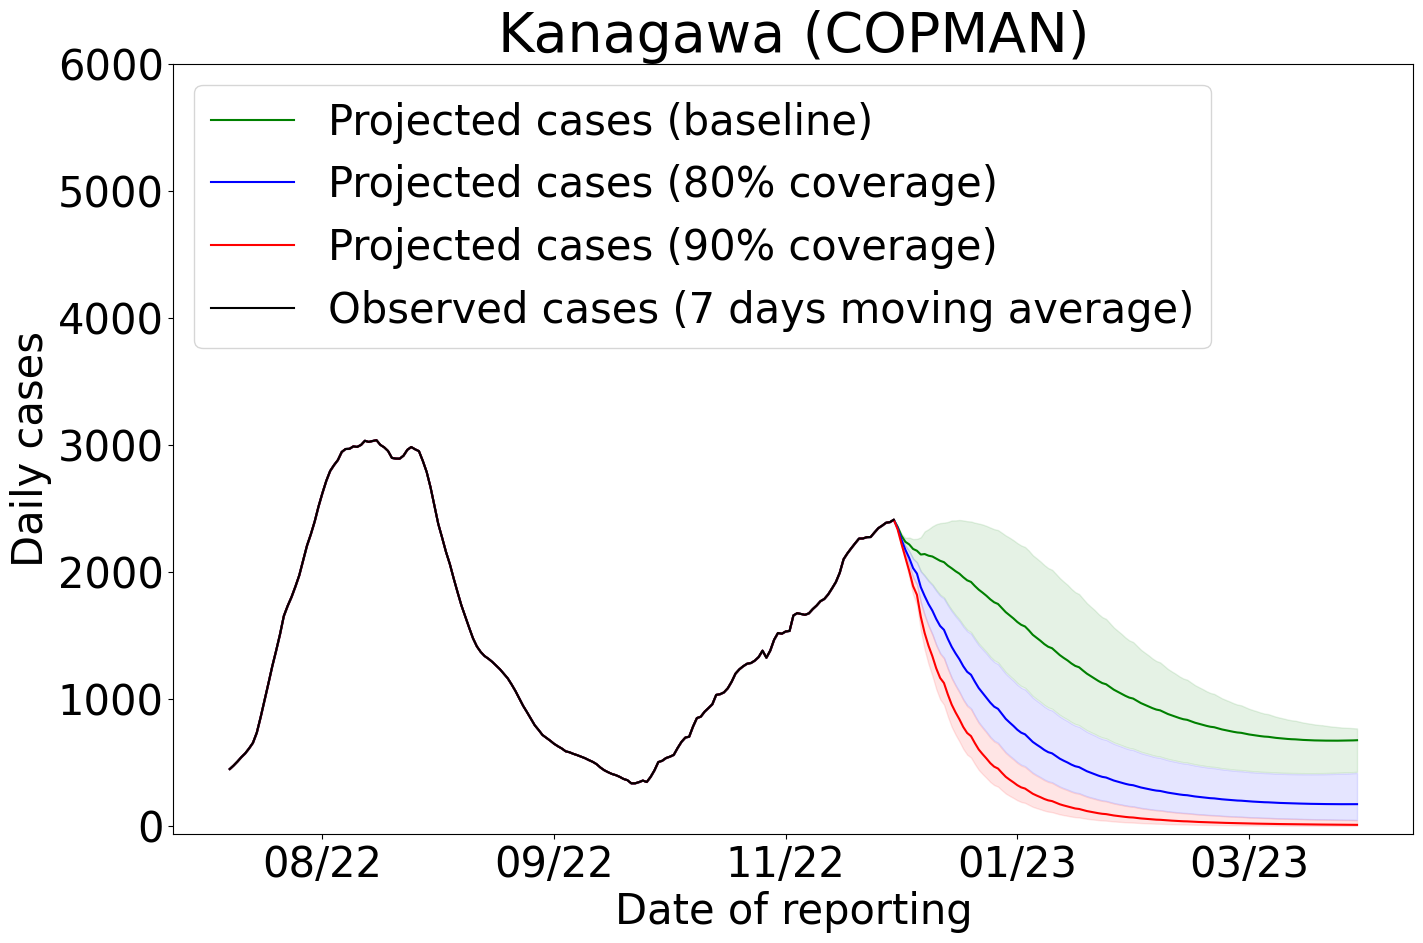

In [21]:
fig = plt.figure(figsize=(16,10))

#plt.plot(date_list_Y0, Y0_movmean, label='Estimated cases: +7d=' + str(round(Y0_movmean[predDay+7],1)) + ', +14d=' + str(round(Y0_movmean[predDay+14],1)) , color = 'g')
#plt.fill_between(date_list_Y0,Y2_movmean, Ym2_movmean, color='g', alpha=0.2, label='Estimated cases 95% C.L.')
#plt.plot(date_list_Y0, Y0_80_movmean, label='Estimated cases (VR=0.8): +7d=' + str(round(Y0_80_movmean[predDay+7],1)) + ', +14d=' + str(round(Y0_80_movmean[predDay+14],1)) , color = 'b',  linestyle="dotted")
#plt.fill_between(date_list_Y0,Y2_80_movmean, Ym2_80_movmean, color='b', alpha=0.2, label='Estimated value (VR=0.8) 95% C.L.')
#plt.plot(date_list_Y0, Y0_90_movmean, label='Estimated cases (VR=0.9): +7d=' + str(round(Y0_90_movmean[predDay+7],1)) + ', +14d=' + str(round(Y0_90_movmean[predDay+14],1)) , color = 'r',  linestyle="dotted")
#plt.fill_between(date_list_Y0,Y2_90_movmean, Ym2_90_movmean, color='r', alpha=0.2, label='Estimated value (VR=0.9) 95% C.L.')
#plt.plot(date_list_YC, YC_movmean, label='Reported cases rolling mean(-7d)', color='k')

plt.plot(date_list_Y0, Y0_movmean,    label='Projected cases (baseline)' , color = 'g')
plt.fill_between(date_list_Y0,Y2_movmean, Ym2_movmean, color='g', alpha=0.1)
plt.plot(date_list_Y0, Y0_80_movmean, label='Projected cases (80% coverage)', color = 'b')
plt.fill_between(date_list_Y0,Y2_80_movmean, Ym2_80_movmean, color='b', alpha=0.1)
plt.plot(date_list_Y0, Y0_90_movmean, label='Projected cases (90% coverage)', color = 'r')
plt.fill_between(date_list_Y0,Y2_90_movmean, Ym2_90_movmean, color='r', alpha=0.1)
plt.plot(date_list_YC, YC_movmean, label='Observed cases (7 days moving average)', color='k')

if figure_title=="City A (EPISENS-S)":
    plt.ylim([-50,500]) #city-a 
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-3000/100,3000]) #Kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-6000/100,6000]) # kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-6000/100,6000]) # kanagawa
plt.title(figure_title, fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Daily cases',fontsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

plt.legend(fontsize=30,loc="upper left")
plt.tick_params(labelsize=30)

plt.savefig(outputfile + '/Long_estimate_the_case_numbers_' + regionName + '.png',bbox_inches="tight") 
pdf.savefig(fig,bbox_inches="tight")

In [22]:
YC_cumsum = np.cumsum(YC)

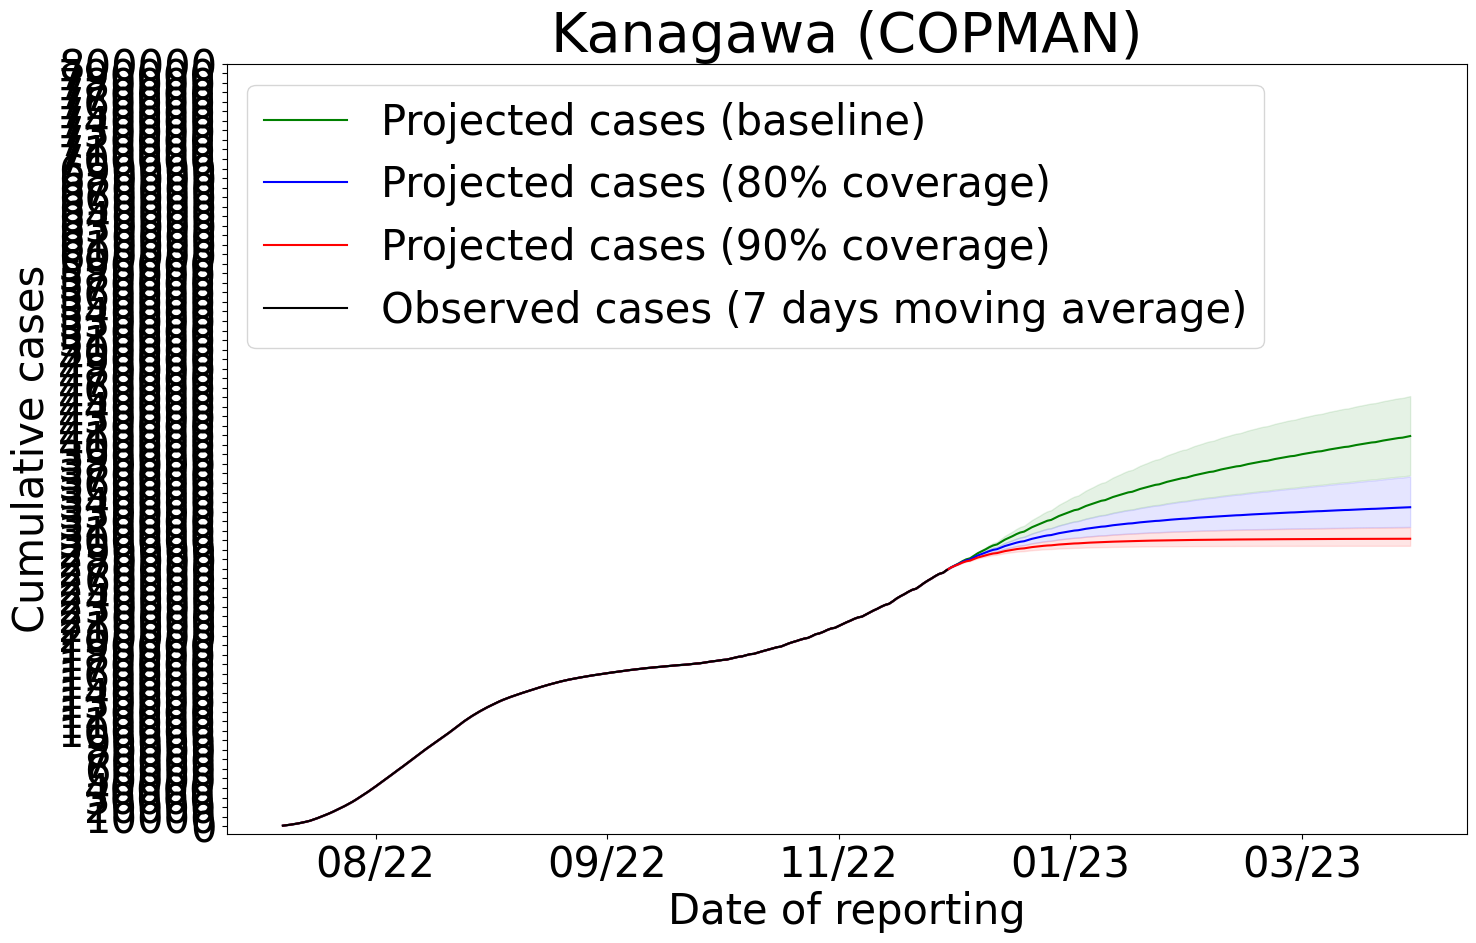

In [23]:
fig = plt.figure(figsize=(16,10))

#plt.plot(date_list_Y0, Yc0, label='Estimated cases', color='g')
#plt.fill_between(date_list_Y0,Yc2, Ycm2, color='g', alpha=0.2, label='Estimated cases 95% C.L.')
#plt.plot(date_list_Y0, Yc0_80, label='Estimated cases (VR=0.8)' , color = 'b',  linestyle="dotted")
#plt.fill_between(date_list_Y0,Yc2_80, Ycm2_80, color='b', alpha=0.2, label='Estimated cases (VR=0.8) 95% C.L.')
#plt.plot(date_list_Y0, Yc0_90, label='Estimated cases (VR=0.9)' , color = 'r',  linestyle="dotted")
#plt.fill_between(date_list_Y0,Yc2_90, Ycm2_90, color='r', alpha=0.2, label='Estimated cases (VR=0.9) 95% C.L.')
#plt.plot(date_list_YC, YC_cumsum, label='Reported cases rolling mean(-7d)', color='k')

plt.plot(date_list_Y0, Yc0, label   ='Projected cases (baseline)', color='g')
plt.fill_between(date_list_Y0,Yc2, Ycm2, color='g', alpha=0.1)
plt.plot(date_list_Y0, Yc0_80, label='Projected cases (80% coverage)' , color = 'b')
plt.fill_between(date_list_Y0,Yc2_80, Ycm2_80, color='b', alpha=0.1)
plt.plot(date_list_Y0, Yc0_90, label='Projected cases (90% coverage)' , color = 'r')
plt.fill_between(date_list_Y0,Yc2_90, Ycm2_90, color='r', alpha=0.1)
plt.plot(date_list_YC, YC_cumsum, label='Observed cases (7 days moving average)', color='k')

plt.title(figure_title, fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Cumulative cases',fontsize=30)
if figure_title=="City A (EPISENS-S)":
    plt.ylim([-1e3,3e4]) # Takmatsu
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-1e3,3e5]) # Kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-8e5/100,8e5]) # Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-8e5/100,8e5]) # Kanagawa

plt.legend(fontsize=30,loc="upper left")
plt.tick_params(labelsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
# Set tick frequency
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e4))
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

plt.savefig(outputfile + '/Long_estimate_the_case_numbers_cumulative_' + regionName + '.png',bbox_inches="tight")
pdf.savefig(fig,bbox_inches="tight")

In [24]:
# Long estimate the case numbers (vaccination scenario, transition to R after vaccination) 
# At what date is the forward prediction done
predDay = len(YC)
# Use case/WW data or both
dataToUse = [True, True]

params['RW'] = params['RW0']/10
result = SEIR_WW(params,YC,YW,C,dataToUse,predDay, s_init)
XendC = result[1].T[0]
PC = result[2]

Y0, err = SEIR_WW_FWD(XendC,C,PC,predDay,params,N_days_pred)
Xaux_80 = np.copy(XendC)
Xaux_80[0] = Xaux_80[0] - Xaux_80[0] * (0.8 - acutial_vaccination_rate) * vaccine_efficacy_rate
Y0_80, err_80 = SEIR_WW_FWD(Xaux_80,C,PC,predDay,params,N_days_pred)
Xaux_90 = np.copy(XendC)
Xaux_90[0] = Xaux_90[0] - Xaux_90[0] * (0.9 - acutial_vaccination_rate) * vaccine_efficacy_rate
Y0_90, err_90 = SEIR_WW_FWD(Xaux_90,C,PC,predDay,params,N_days_pred)
Yc0 = np.cumsum(np.hstack([YC[0:predDay],Y0[0,:]]))
Yc0_80 = np.cumsum(np.hstack([YC[0:predDay],Y0_80[0,:]]))
Yc0_90 = np.cumsum(np.hstack([YC[0:predDay],Y0_90[0,:]]))

# actual vacctination rate
Xaux = np.copy(XendC)
Xaux[6] = XendC[6] + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Y2 = result[0]
Yc2 = np.cumsum(np.hstack([YC[0:predDay],Y2[0,:]]))

Xaux[6] = XendC[6] - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Ym2 = result[0]
Ycm2 = np.cumsum(np.hstack([YC[0:predDay],Ym2[0,:]]))

# 80 percent vacctination rate
Xaux_80[6] = XendC[6] + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux_80,C,PC,predDay,params,N_days_pred)
Y2_80 = result[0]
Yc2_80 = np.cumsum(np.hstack([YC[0:predDay],Y2_80[0,:]]))

Xaux_80[6] = XendC[6] - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux_80,C,PC,predDay,params,N_days_pred)
Ym2_80 = result[0]
Ycm2_80 = np.cumsum(np.hstack([YC[0:predDay],Ym2_80[0,:]]))

# 90 percent vacctination rate
Xaux_90[6] = XendC[6] + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux_90,C,PC,predDay,params,N_days_pred)
Y2_90 = result[0]
Yc2_90 = np.cumsum(np.hstack([YC[0:predDay],Y2_90[0,:]]))

Xaux_90[6] = XendC[6] - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux_90,C,PC,predDay,params,N_days_pred)
Ym2_90 = result[0]
Ycm2_90 = np.cumsum(np.hstack([YC[0:predDay],Ym2_90[0,:]]))

In [25]:
Y0_movmean = pd.Series(np.hstack([YC[0:predDay],Y0[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_movmean = pd.Series(np.hstack([YC[0:predDay],Y2[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2[0,:]])).rolling(window=7, min_periods=1).mean()

Y0_80_movmean = pd.Series(np.hstack([YC[0:predDay],Y0_80[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_80_movmean = pd.Series(np.hstack([YC[0:predDay],Y2_80[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_80_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2_80[0,:]])).rolling(window=7, min_periods=1).mean()

Y0_90_movmean = pd.Series(np.hstack([YC[0:predDay],Y0_90[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_90_movmean = pd.Series(np.hstack([YC[0:predDay],Y2_90[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_90_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2_90[0,:]])).rolling(window=7, min_periods=1).mean()

YC_movmean = YC.rolling(window=7, min_periods=1).mean()

In [26]:
date_list_Y0 = pd.date_range(TT['date'][0], periods = len(Y0_movmean), freq = 'D')
date_list_YC = pd.date_range(TT['date'][0], periods = len(YC_movmean), freq = 'D')

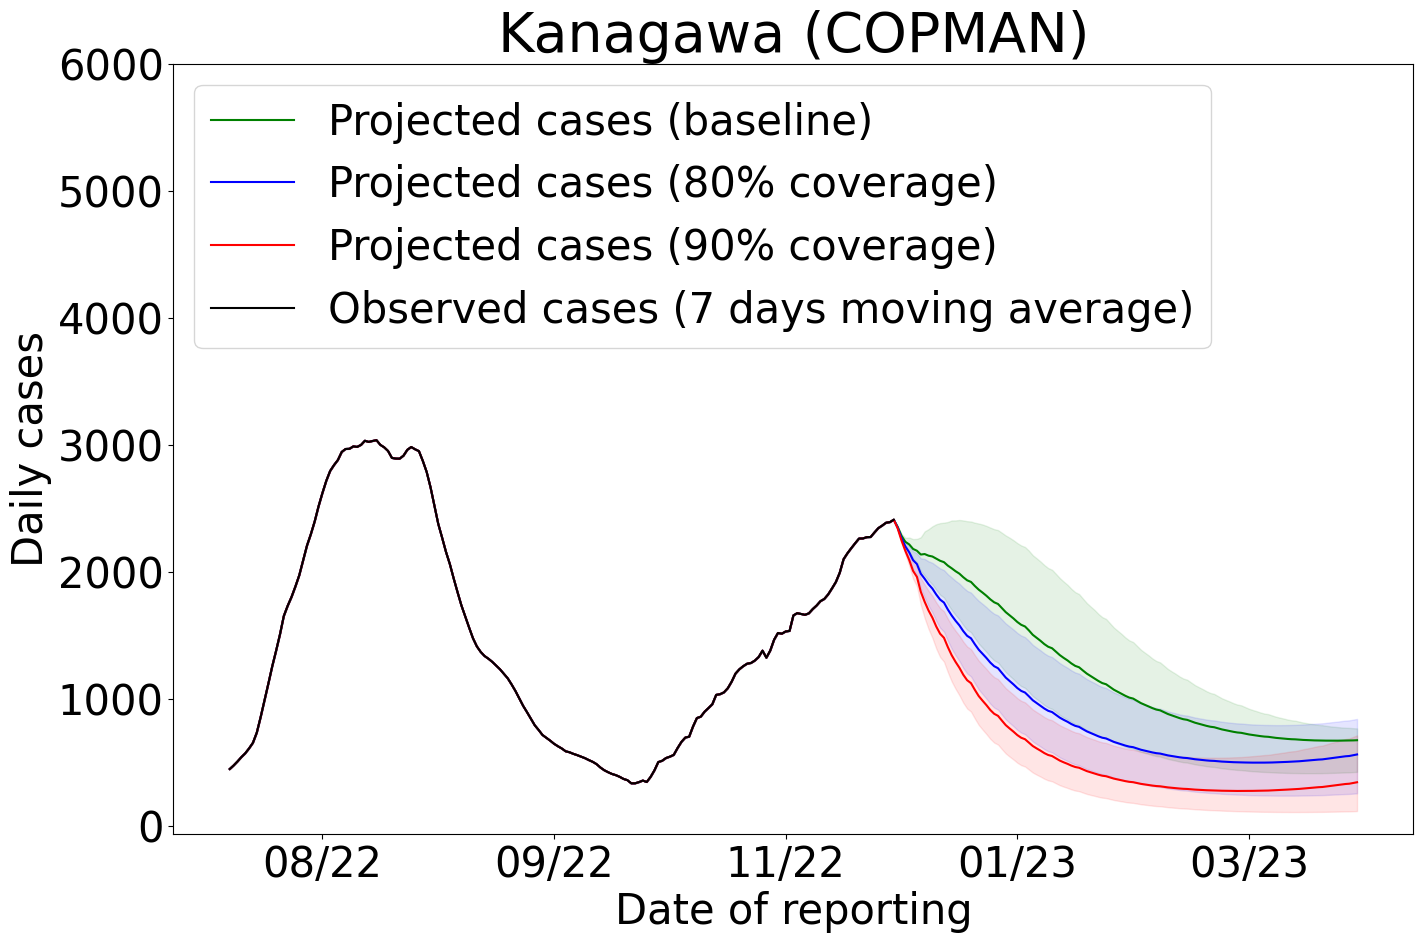

In [27]:
fig = plt.figure(figsize=(16,10))

plt.plot(date_list_Y0, Y0_movmean,    label='Projected cases (baseline)' , color = 'g')
plt.plot(date_list_Y0, Y0_80_movmean, label='Projected cases (80% coverage)', color = 'b')
plt.plot(date_list_Y0, Y0_90_movmean, label='Projected cases (90% coverage)', color = 'r')

plt.fill_between(date_list_Y0,Y2_movmean, Ym2_movmean, color='g', alpha=0.1)
plt.fill_between(date_list_Y0,Y2_80_movmean, Ym2_80_movmean, color='b', alpha=0.1)
plt.fill_between(date_list_Y0,Y2_90_movmean, Ym2_90_movmean, color='r', alpha=0.1)

plt.plot(date_list_YC, YC_movmean, label='Observed cases (7 days moving average)', color='k')
if figure_title=="City A (EPISENS-S)":
    plt.ylim([-50,500]) #city-a 
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-3000/100,3000]) #Kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-6000/100,6000]) # kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-6000/100,6000]) # kanagawa
plt.title(figure_title, fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Daily cases',fontsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

plt.legend(fontsize=30,loc="upper left")
plt.tick_params(labelsize=30)

plt.savefig(outputfile + '/Long_estimate_the_case_numbers_mod' + regionName + '.png',bbox_inches="tight") 
pdf.savefig(fig,bbox_inches="tight")

In [28]:
YC_cumsum = np.cumsum(YC)

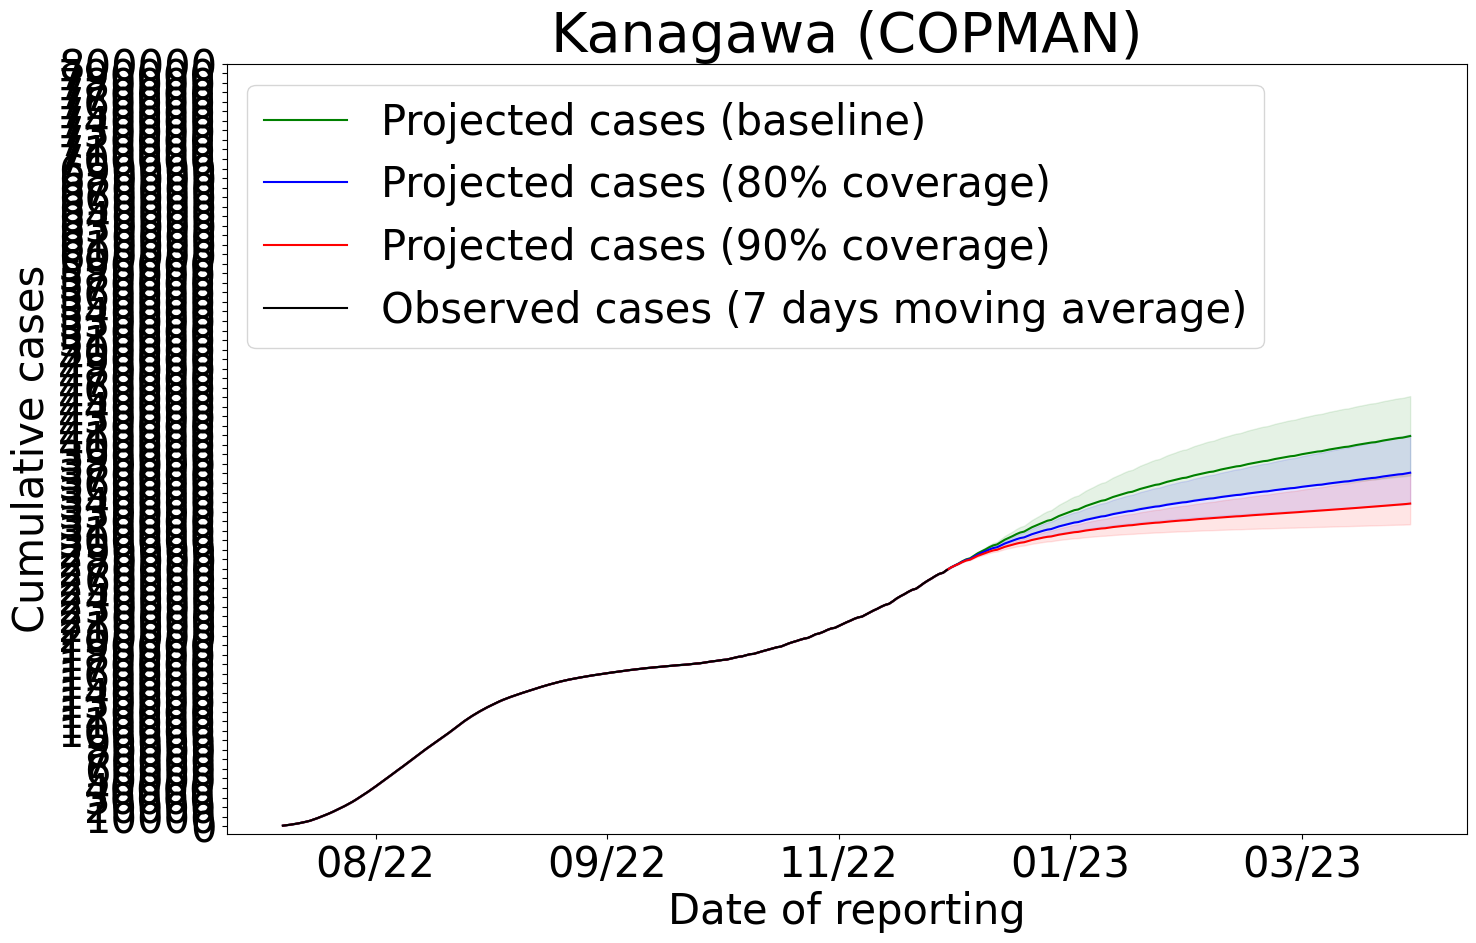

In [29]:
fig = plt.figure(figsize=(16,10))

plt.plot(date_list_Y0, Yc0, label   ='Projected cases (baseline)', color='g')
plt.fill_between(date_list_Y0,Yc2, Ycm2, color='g', alpha=0.1)
plt.plot(date_list_Y0, Yc0_80, label='Projected cases (80% coverage)' , color = 'b')
plt.fill_between(date_list_Y0,Yc2_80, Ycm2_80, color='b', alpha=0.1)
plt.plot(date_list_Y0, Yc0_90, label='Projected cases (90% coverage)' , color = 'r')
plt.fill_between(date_list_Y0,Yc2_90, Ycm2_90, color='r', alpha=0.1)
plt.plot(date_list_YC, YC_cumsum, label='Observed cases (7 days moving average)', color='k')

plt.title(figure_title, fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Cumulative cases',fontsize=30)

if figure_title=="City A (EPISENS-S)":
    plt.ylim([-1e3,3e4]) # Takmatsu
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-1e3,3e5]) # Kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-8e5/100,8e5]) # Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-8e5/100,8e5]) # Kanagawa
plt.legend(fontsize=30,loc="upper left")
plt.tick_params(labelsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
# Set tick frequency
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e4))
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

plt.savefig(outputfile + '/Long_estimate_the_case_numbers_cumulative_mod' + regionName + '.png',bbox_inches="tight")
pdf.savefig(fig,bbox_inches="tight")

In [30]:
# Long estimate the case numbers (contact scenario)
#contact_reduce_rate=0.25
Xaux[6] = XendC[6] * (1 - contact_reduce_rate)
Y0_contact, err_contact = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Yc0_contact = np.cumsum(np.hstack([YC[0:predDay],Y0_contact[0,:]]))

Xaux[6] = XendC[6] * (1 - contact_reduce_rate) + 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Y2_contact = result[0]
Yc2_contact = np.cumsum(np.hstack([YC[0:predDay],Y2_contact[0,:]]))

Xaux[6] = XendC[6] * (1 - contact_reduce_rate) - 2 * PC[6,6]**.5
result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
Ym2_contact = result[0]
Ycm2_contact = np.cumsum(np.hstack([YC[0:predDay],Ym2_contact[0,:]]))

Y0_contact_movmean = pd.Series(np.hstack([YC[0:predDay],Y0_contact[0,:]])).rolling(window=7, min_periods=1).mean()
Y2_contact_movmean = pd.Series(np.hstack([YC[0:predDay],Y2_contact[0,:]])).rolling(window=7, min_periods=1).mean()
Ym2_contact_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2_contact[0,:]])).rolling(window=7, min_periods=1).mean()

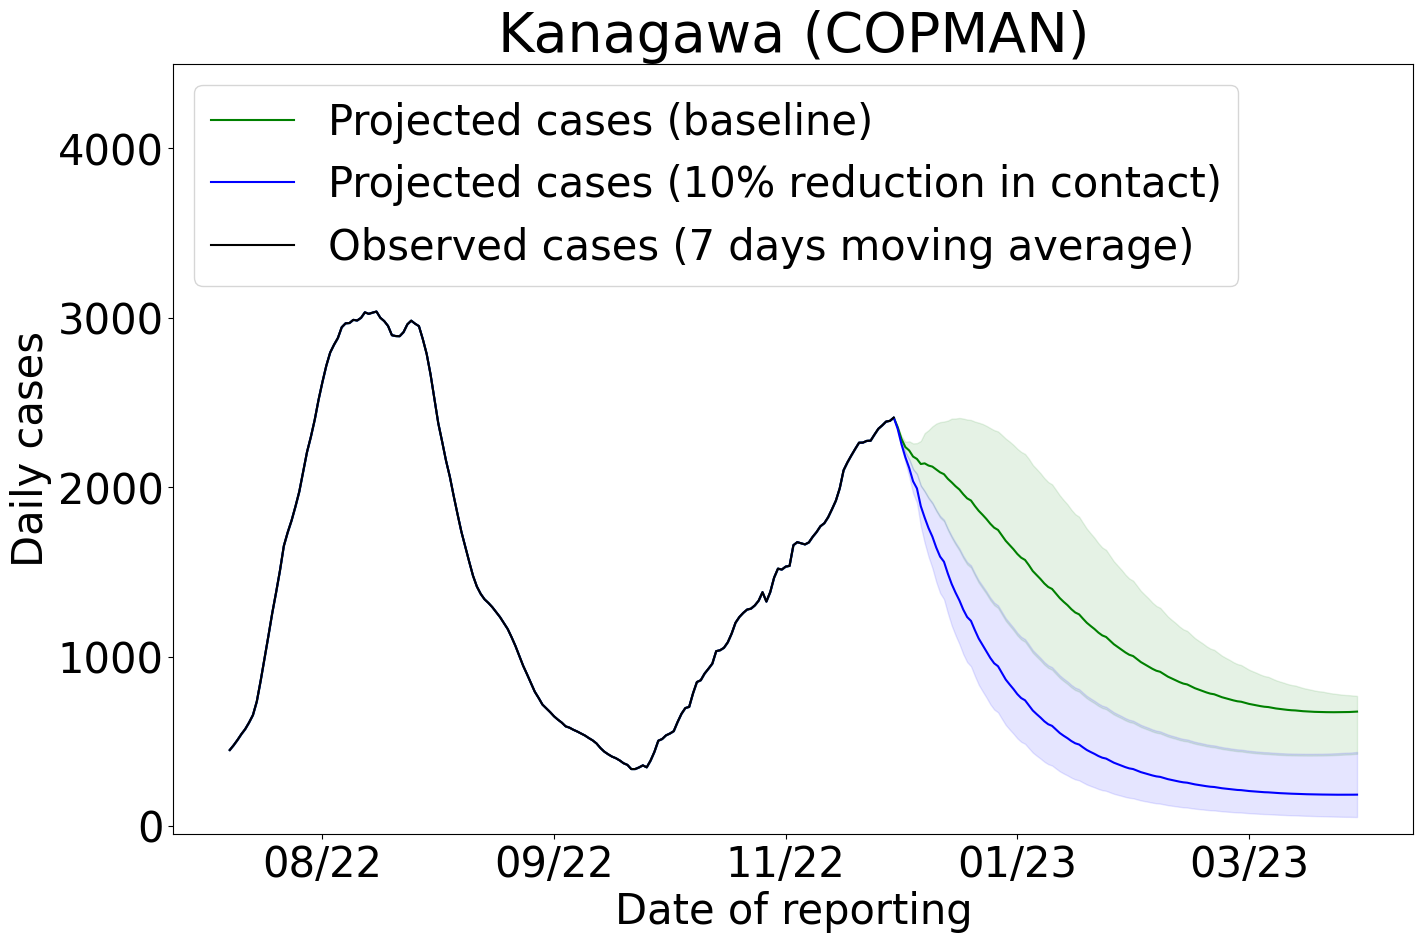

In [31]:
fig = plt.figure(figsize=(16,10))

#plt.plot(date_list_Y0, Y0_movmean, label='Estimated cases: +7d=' + str(round(Y0_movmean[predDay+7],1)) + ', +14d=' + str(round(Y0_movmean[predDay+14],1)) , color = 'g')
#plt.fill_between(date_list_Y0,Y2_movmean, Ym2_movmean, color='g', alpha=0.2, label='Estimated value 95% C.L.')
#plt.plot(date_list_Y0, Y0_contact_movmean, label='Estimated cases (CR): +7d=' + str(round(Y0_contact_movmean[predDay+7],1)) + ', +14d=' + str(round(Y0_contact_movmean[predDay+14],1)) , color = 'b',  linestyle="--")
#plt.fill_between(date_list_Y0,Y2_contact_movmean, Ym2_contact_movmean, color='b', alpha=0.2, label='Estimated value (CR) 95% C.L.')
#plt.plot(date_list_YC, YC_movmean, label='Reported cases rolling mean(-7d)', color='k')

plt.plot(date_list_Y0, Y0_movmean,         label='Projected cases (baseline)', color = 'g')
plt.fill_between(date_list_Y0,Y2_movmean, Ym2_movmean, color='g', alpha=0.1)
plt.plot(date_list_Y0, Y0_contact_movmean, label='Projected cases ('+str(int((contact_reduce_rate)*100)) + "% reduction in contact)", color = 'b')
plt.fill_between(date_list_Y0,Y2_contact_movmean, Ym2_contact_movmean, color='b', alpha=0.1)
plt.plot(date_list_YC, YC_movmean, label='Observed cases (7 days moving average)', color='k')

#plt.title('Long estimate the case numbers (contact reduce rate = ' +  str(contact_reduce_rate) + ')', fontsize=20)
plt.title(figure_title,fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Daily cases',fontsize=30)
if figure_title=="City A (EPISENS-S)":
    plt.ylim([-50,500]) # city-a 
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-3000/100,3000]) # Kyoto 
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-4500/100,4500]) # Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-4500/100,4500]) # Kanagawa

plt.legend(fontsize=30,loc="upper left")
plt.tick_params(labelsize=30)
years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

plt.savefig(outputfile + '/Long_estimate_the_case_numbers_contact_' + regionName + '_' + str(int(contact_reduce_rate*100)) + '.png',bbox_inches="tight") 
pdf.savefig(fig,bbox_inches="tight")

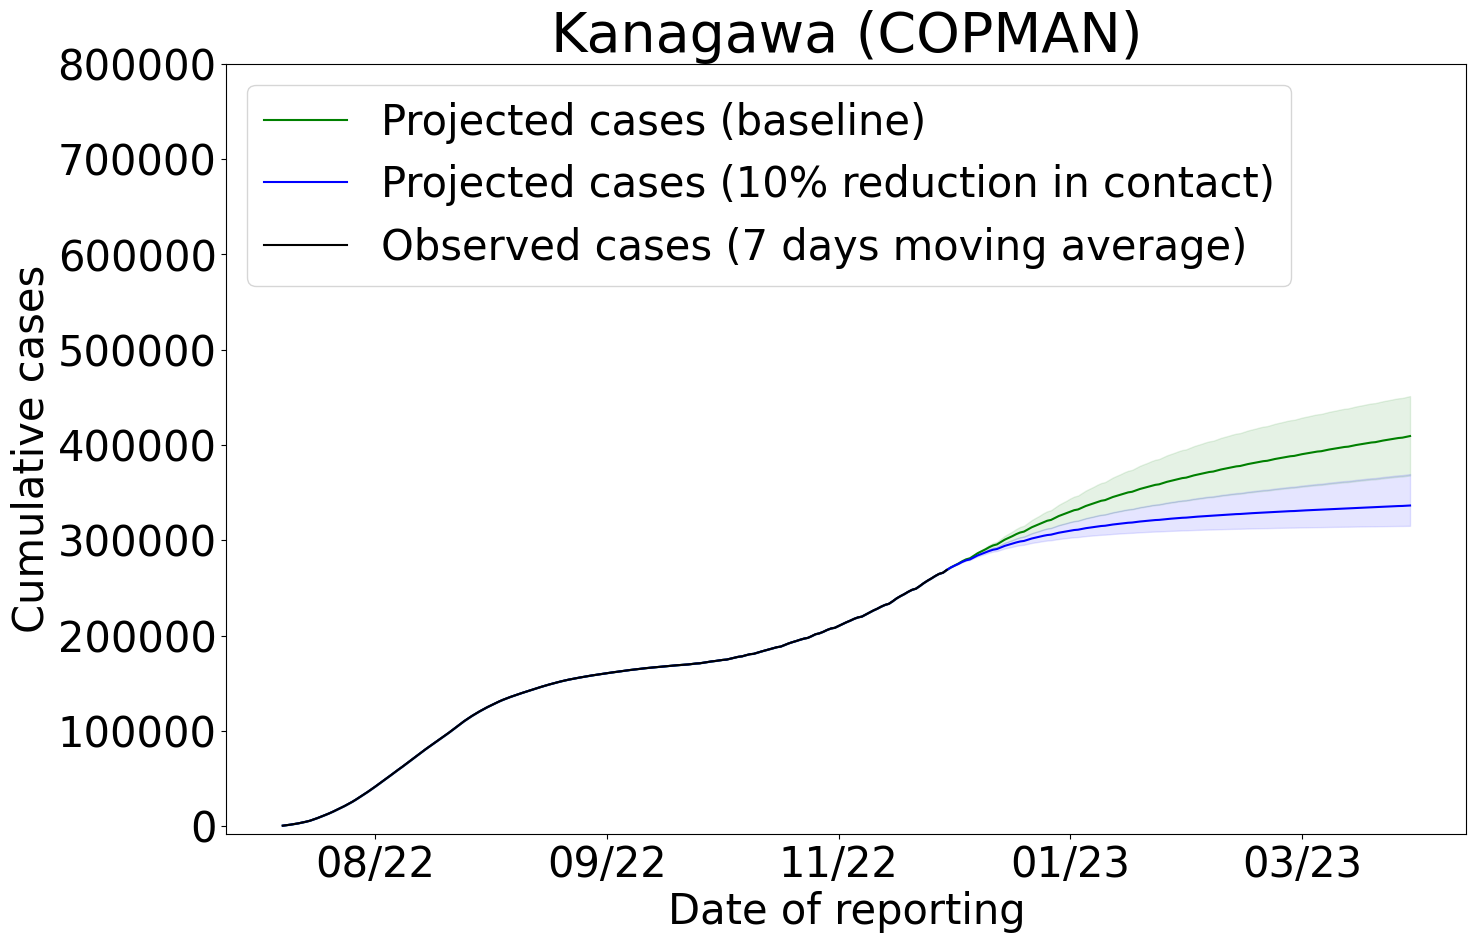

In [32]:
fig = plt.figure(figsize=(16,10))

#plt.plot(date_list_Y0, Yc0, label='Estimated cases', color='g')
#plt.fill_between(date_list_Y0,Yc2, Ycm2, color='g', alpha=0.2, label='Estimated cases 95% C.L.')
#plt.plot(date_list_Y0, Yc0_contact, label='Estimated cases (CR)' , color = 'b',  linestyle="dotted")
#plt.fill_between(date_list_Y0,Yc2_contact, Ycm2_contact, color='b', alpha=0.2, label='Estimated cases (CR) 95% C.L.')
#plt.plot(date_list_YC, YC_cumsum, label='Reported cases rolling mean(-7d)', color='k')
plt.plot(date_list_Y0, Yc0, label='Projected cases (baseline)', color='g')
plt.fill_between(date_list_Y0,Yc2, Ycm2, color='g', alpha=0.1)
plt.plot(date_list_Y0, Yc0_contact, label='Projected cases ('+str(int((contact_reduce_rate)*100)) + "% reduction in contact)" , color = 'b')
plt.fill_between(date_list_Y0,Yc2_contact, Ycm2_contact, color='b', alpha=0.1)
plt.plot(date_list_YC, YC_cumsum, label='Observed cases (7 days moving average)', color='k')

#plt.title('Long estimate the case numbers (contact reduce rate = ' +  str(contact_reduce_rate) + ')', fontsize=15)
plt.title(figure_title,fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Cumulative cases',fontsize=30)
if figure_title=="City A (EPISENS-S)":
    plt.ylim([-1e3,3e4]) # city-a
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-1e3,3e5]) # Kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-8e5/100,8e5]) # Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-8e5/100,8e5]) # Kanagawa

plt.legend(fontsize=30, loc='upper left')
plt.tick_params(labelsize=30)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1e5))
years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

plt.savefig(outputfile + '/Long_estimate_the_case_numbers_cumulative_contact' + regionName + '_' + str(int(contact_reduce_rate*100))+'.png',bbox_inches="tight")
pdf.savefig(fig,bbox_inches="tight")

In [33]:
# 7-day ahead predictions
winLength = 7
WWinds = np.where(YW>-0.5)[0]
excl = np.sum(WWinds + winLength >= len(YC))
WWinds = WWinds[0:len(WWinds)-excl]
trueCases = np.zeros((1,len(WWinds)))
for jd in range(len(WWinds)):
    trueCases[0, jd] = np.sum(YC[WWinds[jd]+1:WWinds[jd]+1+winLength])

predsCase, predsWW, predsWWip, predsBoth = prediction(params, WWinds, YC, YW, C, winLength,s_init)
preds = pd.DataFrame([np.array(TT['date'][WWinds].dt.strftime('%Y-%m-%d')), trueCases[0], predsCase[0], predsWW[0], predsWWip[0],predsBoth[0]],index=['date', 'trueCases', 'predsCase', 'predsWW', 'predsWWip', 'predsBoth']).T
preds.to_csv('./results/' + regionName + '/pred' + str(winLength) + 'days_' + params['region'] + '.csv', index=False)

In [34]:
mae_cs = round(mean_absolute_error(trueCases, predsCase),3)
rmse_cs = round(np.sqrt(mean_squared_error(trueCases, predsCase)),3)
mae_ww = round(mean_absolute_error(trueCases, predsWW),3)
rmse_ww = round(np.sqrt(mean_squared_error(trueCases, predsWW)),3)
mae_bh = round(mean_absolute_error(trueCases, predsBoth),3)
rmse_bh = round(np.sqrt(mean_squared_error(trueCases, predsBoth)),3)

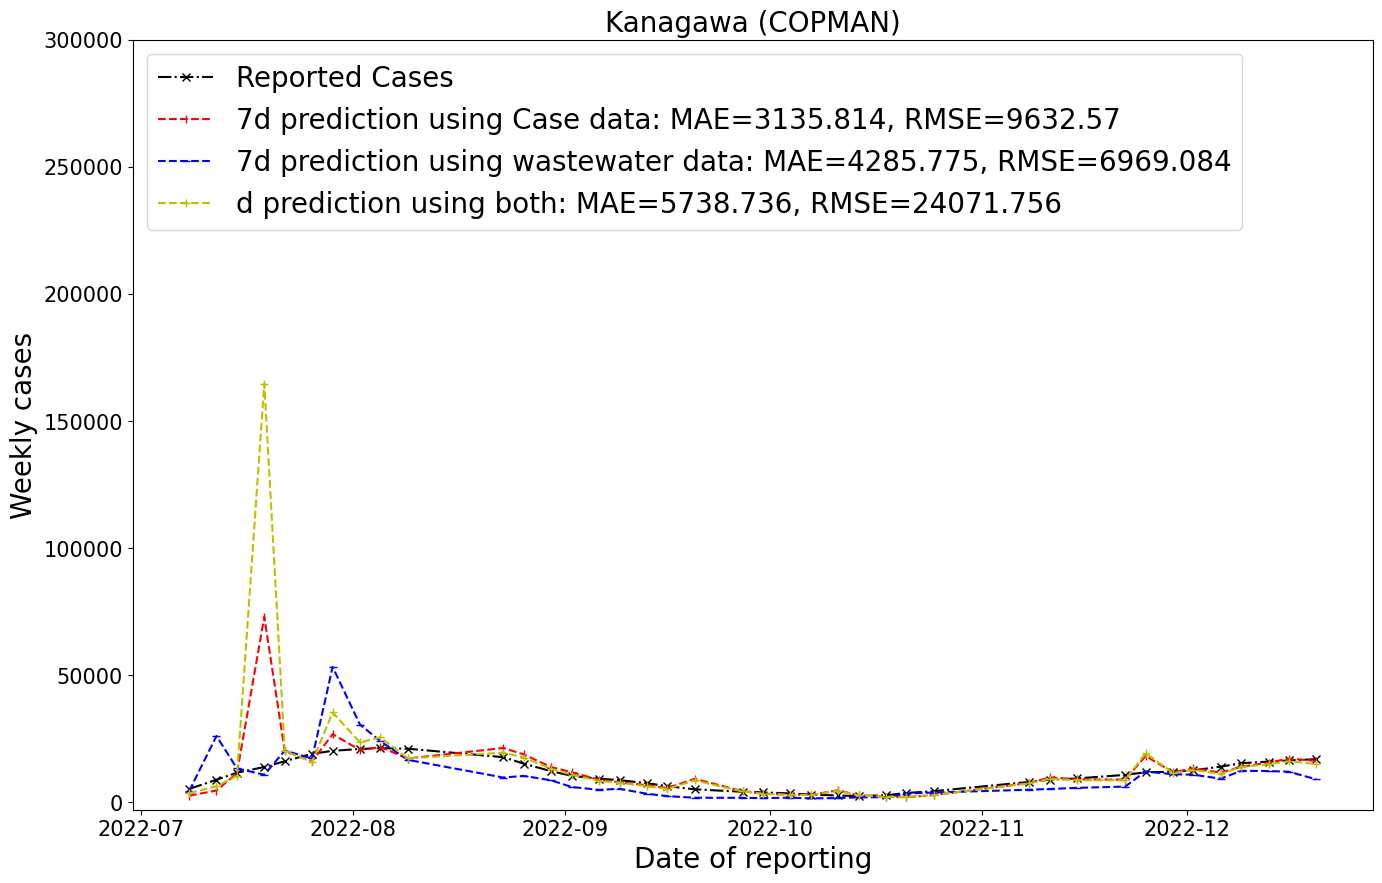

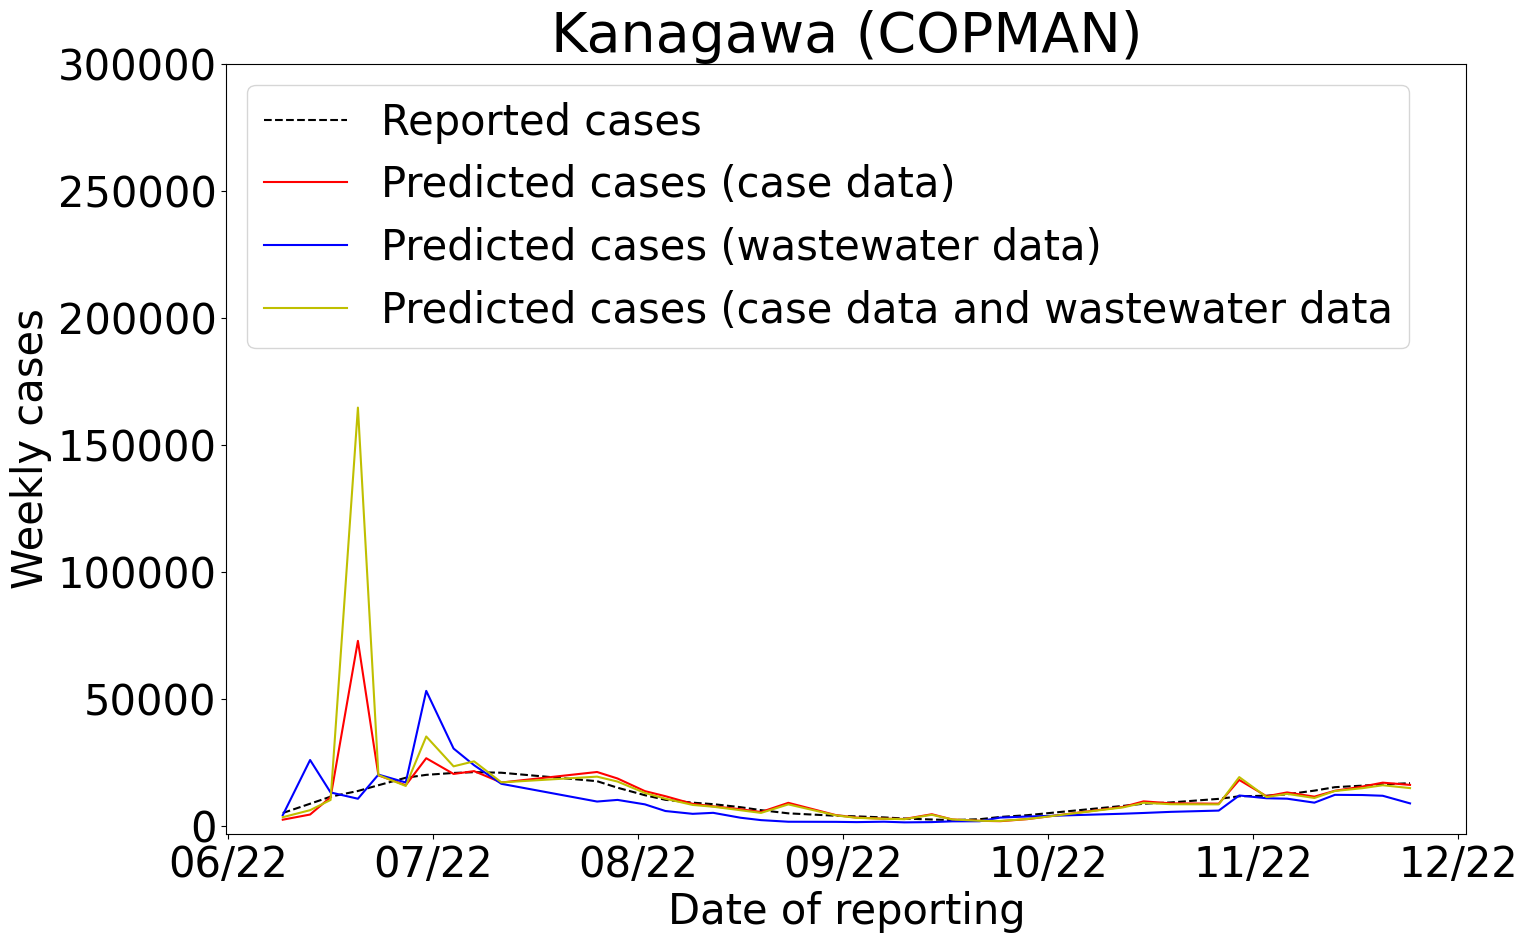

In [35]:
fig = plt.figure(figsize=(16,10))

plt.plot(TT['date'][WWinds], trueCases[0], label='Reported Cases',  ls='-.' ,  marker='x', color='k')
plt.plot(TT['date'][WWinds], predsCase[0], label=str(winLength)+'d prediction using Case data: MAE=' + str(mae_cs) + ', RMSE=' + str(rmse_cs), ls='--',  marker='|', color='r')
plt.plot(TT['date'][WWinds], predsWW[0], label=str(winLength)+'d prediction using wastewater data: MAE=' + str(mae_ww) + ', RMSE=' + str(rmse_ww), ls='--',  marker='_', color='b')
plt.plot(TT['date'][WWinds], predsBoth[0], label='d prediction using both: MAE=' + str(mae_bh) + ', RMSE=' + str(rmse_bh), ls='--',  marker='+', color='y')

plt.title(figure_title,fontsize=20)
plt.xlabel('Date of reporting',fontsize=20)
plt.ylabel('Weekly cases',fontsize=20)
if figure_title=="City A (EPISENS-S)":
    plt.ylim([-50,2500]) # city-a
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-1e3,6e4]) # kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-30e4/100,30e4]) # Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-30e4/100,30e4]) # Kanagawa
plt.legend(fontsize=20, loc="upper left")
plt.tick_params(labelsize=15)

plt.savefig(outputfile + '/Prediction_time_seriese_7days_original_' + regionName + '.png',bbox_inches="tight")
pdf.savefig(fig,bbox_inches="tight")

fig = plt.figure(figsize=(16,10))

plt.plot(TT['date'][WWinds], trueCases[0], label='Reported cases', color='k', ls="--")
plt.plot(TT['date'][WWinds], predsCase[0], label='Predicted cases (case data)', color='r')
plt.plot(TT['date'][WWinds], predsWW[0],   label='Predicted cases (wastewater data)', color='b')
plt.plot(TT['date'][WWinds], predsBoth[0], label='Predicted cases (case data and wastewater data', color='y')

plt.title(figure_title,fontsize=40)
plt.xlabel('Date of reporting',fontsize=30)
plt.ylabel('Weekly cases',fontsize=30)
if figure_title=="City A (EPISENS-S)":
    plt.ylim([-50,2500]) # city-a
elif figure_title=="Kyoto (COPMAN)":
    plt.ylim([-1e3,6e4]) # kyoto
elif figure_title=="Kanagawa (COPMAN)":
    plt.ylim([-30e4/100,30e4]) # Kanagawa
elif figure_title=="Kanagawa (EPISENS-S)":
    plt.ylim([-30e4/100,30e4]) # Kanagawa
    
plt.legend(fontsize=30, loc="upper left")
plt.tick_params(labelsize=30)

years_fmt = mdates.DateFormatter('%m/%y')
plt.gca().xaxis.set_major_formatter(years_fmt)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

plt.savefig(outputfile + '/Prediction_time_seriese_7days_' + regionName + '.png',bbox_inches="tight")
pdf.savefig(fig,bbox_inches="tight")

In [36]:
pdf.close()

In [37]:
# Loop contact rate
for contact_reduce_rate in 0.15, 0.20, 0.25, 0.30:
    Xaux[6] = XendC[6] * (1 - contact_reduce_rate)
    Y0_contact, err_contact = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
    Yc0_contact = np.cumsum(np.hstack([YC[0:predDay],Y0_contact[0,:]]))

    Xaux[6] = XendC[6] * (1 - contact_reduce_rate) + 2 * PC[6,6]**.5
    result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
    Y2_contact = result[0]
    Yc2_contact = np.cumsum(np.hstack([YC[0:predDay],Y2_contact[0,:]]))

    Xaux[6] = XendC[6] * (1 - contact_reduce_rate) - 2 * PC[6,6]**.5
    result = SEIR_WW_FWD(Xaux,C,PC,predDay,params,N_days_pred)
    Ym2_contact = result[0]
    Ycm2_contact = np.cumsum(np.hstack([YC[0:predDay],Ym2_contact[0,:]]))

    Y0_contact_movmean = pd.Series(np.hstack([YC[0:predDay],Y0_contact[0,:]])).rolling(window=7, min_periods=1).mean()
    Y2_contact_movmean = pd.Series(np.hstack([YC[0:predDay],Y2_contact[0,:]])).rolling(window=7, min_periods=1).mean()
    Ym2_contact_movmean = pd.Series(np.hstack([YC[0:predDay],Ym2_contact[0,:]])).rolling(window=7, min_periods=1).mean()
    fig = plt.figure(figsize=(16,10))
    plt.plot(date_list_Y0, Y0_movmean,         label='Projected cases (baseline)', color = 'g')
    plt.fill_between(date_list_Y0,Y2_movmean, Ym2_movmean, color='g', alpha=0.1)
    plt.plot(date_list_Y0, Y0_contact_movmean, label='Projected cases ('+str(int((contact_reduce_rate)*100)) + "% reduction in contact)", color = 'b')
    plt.fill_between(date_list_Y0,Y2_contact_movmean, Ym2_contact_movmean, color='b', alpha=0.1)
    plt.plot(date_list_YC, YC_movmean, label='Observed cases (7 days moving average)', color='k')

    #plt.title('Long estimate the case numbers (contact reduce rate = ' +  str(contact_reduce_rate) + ')', fontsize=20)
    plt.title(figure_title,fontsize=40)
    plt.xlabel('Date of reporting',fontsize=30)
    plt.ylabel('Daily cases',fontsize=30)
    if figure_title=="City A (EPISENS-S)":
        plt.ylim([-50,500]) # city-a 
    elif figure_title=="Kyoto (COPMAN)":
        plt.ylim([-3000/100,3000]) # Kyoto 
    elif figure_title=="Kanagawa (COPMAN)":
        plt.ylim([-4500/100,4500]) # Kanagawa
    elif figure_title=="Kanagawa (EPISENS-S)":
        plt.ylim([-4500/100,4500]) # Kanagawa

    plt.legend(fontsize=30,loc="upper left")
    plt.tick_params(labelsize=30)
    years_fmt = mdates.DateFormatter('%m/%y')
    plt.gca().xaxis.set_major_formatter(years_fmt)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

    plt.savefig(outputfile + '/Long_estimate_the_case_numbers_contact_' + regionName + '_' + str(int(contact_reduce_rate*100)) + '.png',bbox_inches="tight") 
    plt.clf()

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

<Figure size 1600x1000 with 0 Axes>

In [38]:
outputfile

'./results/Kanagawa'